# 1D Convolutional Autoencoder

## Imports and Data Loading

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import optax
import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training.train_state import TrainState
from datasets import load_dataset
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

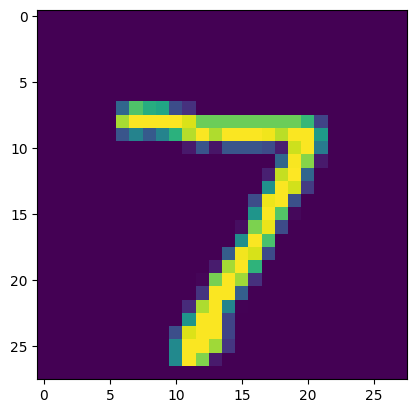

In [3]:
mnist = load_dataset('mnist')
train_set = mnist['train'].with_format('jax')
test_set = mnist['test'].with_format('jax')
plt.imshow(test_set[0]['image'])

## Model Definition

In [4]:
class ConvAutoencoder(nn.Module):
    latent_dim: int
    hidden_dims: list
    block_depth: int
    kernel_dim: int

    @nn.compact
    def __call__(self, x):
        # Encoder
        for hidden_dim in self.hidden_dims:
            for _ in range(self.block_depth):
                x = nn.Conv(features=hidden_dim, kernel_size=(self.kernel_dim,), strides=(1,), padding='SAME')(x)
                x = nn.relu(x)
            x = nn.max_pool(x, window_shape=(2,), strides=(2,))
        z = nn.DenseGeneral(features=self.latent_dim, axis=(-1, -2))(x)

        # Decoder
        x = nn.DenseGeneral(features=(x.shape[1], self.hidden_dims[-1]), axis=-1)(z)
        for hidden_dim in reversed(self.hidden_dims):
            x = jax.image.resize(x, shape=(x.shape[0], x.shape[1]*2, x.shape[2]), method='nearest')
            for _ in range(self.block_depth):
                x = nn.Conv(features=hidden_dim, kernel_size=(self.kernel_dim,), strides=(1,), padding='SAME')(x)
                x = nn.relu(x)
        x = nn.Conv(features=1, kernel_size=(self.kernel_dim,), strides=(1,), padding='SAME')(x)
        return x

## Initialization

In [5]:
preview_sample = jnp.expand_dims(test_set[20]['image'], axis=0)
input_width = preview_sample.shape[1]
input_height = preview_sample.shape[2]
sequence_length = input_width * input_height

num_epochs = 10
batch_size = 32

model = ConvAutoencoder(latent_dim=4, hidden_dims=[8, 16, 32, 64], block_depth=4, kernel_dim=4)
params = model.init(jax.random.PRNGKey(0), jnp.ones((batch_size, sequence_length, 1)))['params']
opt = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=model.apply, params=params, tx=opt)

steps_per_train = len(train_set) // batch_size
steps_per_test = len(test_set) // batch_size

## Train Loop

In [ ]:
def preprocess(x):
    return jax.vmap(lambda x: jnp.expand_dims(jnp.ravel(x), axis=-1))(x) / 255.0

@jax.jit
def train_step(state, x):
    x = preprocess(x)

    def loss_fn(params):
        x_hat = state.apply_fn({'params': params}, x)
        return jnp.mean((x_hat - x)**2)

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jax.jit
def test_step(state, x):
    x = preprocess(x)
    x_hat = state.apply_fn({'params': state.params}, x)
    return jnp.mean((x_hat - x)**2)

@jax.jit
def reconstruct(state, x):
    x = preprocess(x)
    x_hat = state.apply_fn({'params': state.params}, x)
    return x_hat

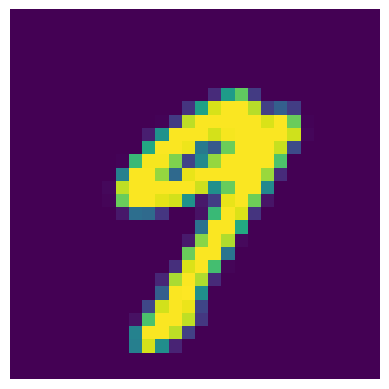

epoch 0, train loss 0.045737627893686295, test loss 0.037264030426740646


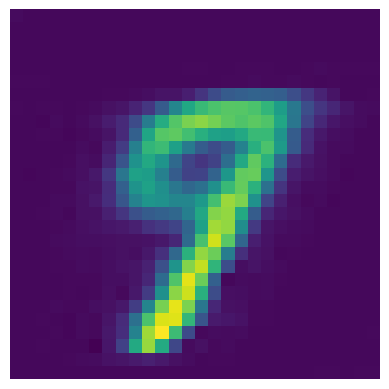

epoch 1, train loss 0.0356220118701458, test loss 0.03409470617771149


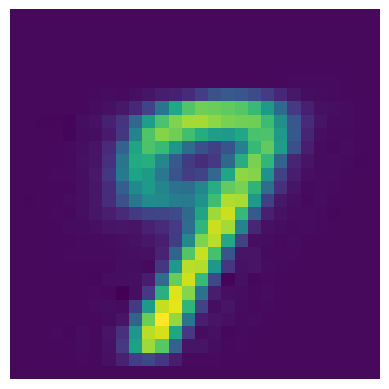

epoch 2, train loss 0.03376064822077751, test loss 0.03379996865987778


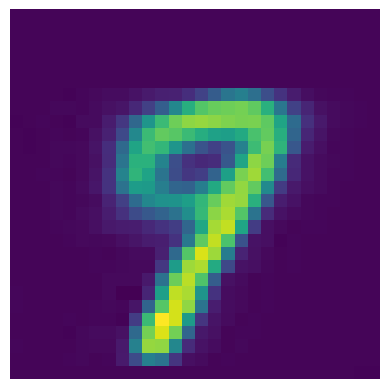

epoch 3, train loss 0.03267771378159523, test loss 0.032536253333091736


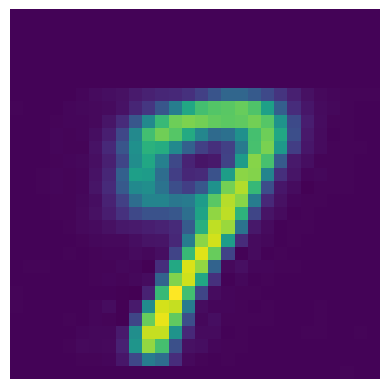

epoch 4, train loss 0.031747907400131226, test loss 0.030968504026532173


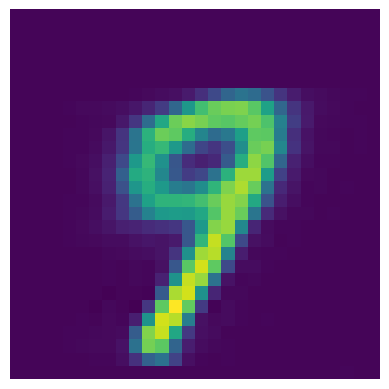

epoch 5, train loss 0.031069522723555565, test loss 0.030652297660708427


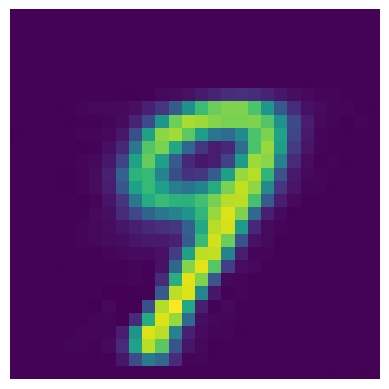

epoch 6, train loss 0.030535314232110977, test loss 0.030320867896080017


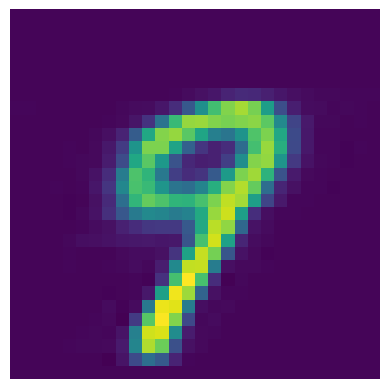

epoch 7, train loss 0.03002900443971157, test loss 0.02963349223136902


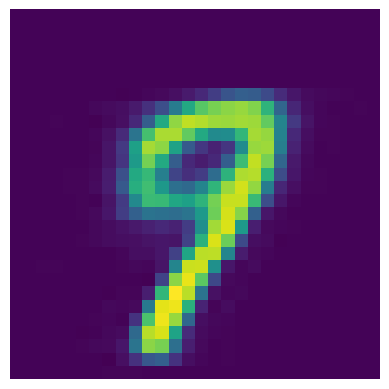

epoch 8, train loss 0.029639126732945442, test loss 0.029680442065000534


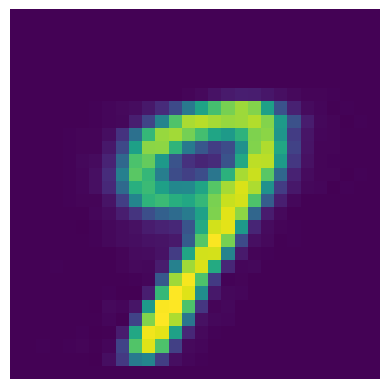

epoch 9, train loss 0.029314391314983368, test loss 0.029350489377975464


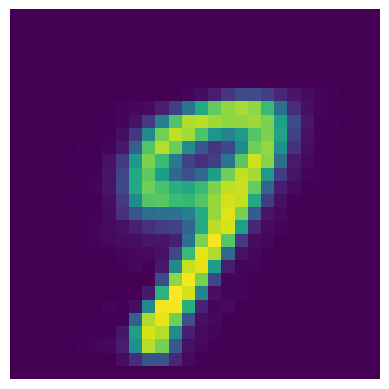

In [7]:
def display_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

display_image(preview_sample.squeeze())

per_epoch_train_loss = []
per_epoch_test_loss = []
for epoch in range(num_epochs):
    train_set = train_set.shuffle(seed=epoch)
    train_iterator = train_set.iter(batch_size)
    train_losses = []
    for step in range(steps_per_train):
        x = next(train_iterator)['image']
        loss, state = train_step(state, x)
        train_losses.append(loss)

    test_set = test_set.shuffle(seed=epoch)
    test_iterator = train_set.iter(batch_size)
    test_losses = []
    for step in range(steps_per_test):
        x = next(test_iterator)['image']
        loss = test_step(state, x)
        test_losses.append(loss)

    average_train_loss = sum(train_losses) / len(train_losses)
    average_test_loss = sum(test_losses) / len(test_losses)
    per_epoch_train_loss.append(average_train_loss)
    per_epoch_test_loss.append(average_test_loss)
    print(f'epoch {epoch}, train loss {average_train_loss}, test loss {average_test_loss}')

    rec = reconstruct(state, preview_sample)
    rec = jnp.reshape(rec, (input_width, input_height)) * 255.0
    display_image(rec)

## Performance Visualization

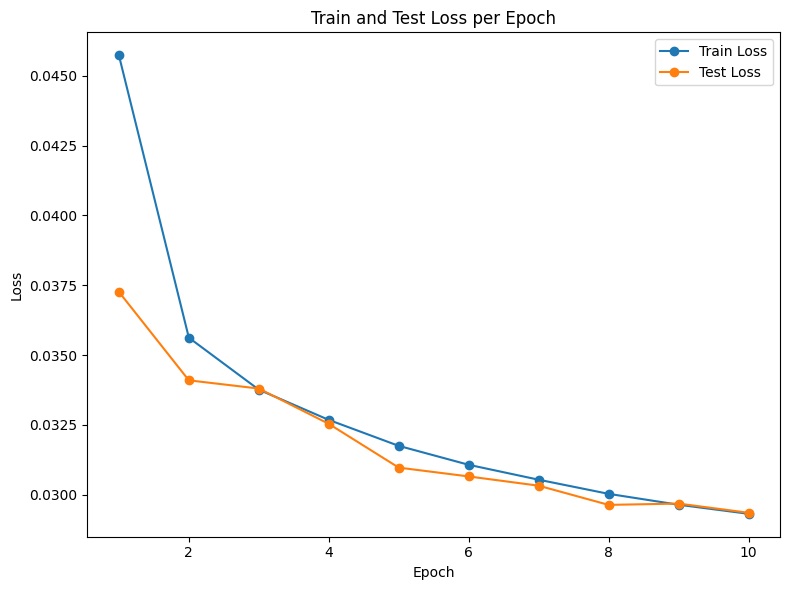

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, num_epochs + 1), per_epoch_train_loss, marker='o', label='Train Loss')
ax.plot(range(1, num_epochs + 1), per_epoch_test_loss, marker='o', label='Test Loss')

ax.set_title('Train and Test Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()

plt.tight_layout()
plt.show()